In [17]:
import scanpy as sc
from pathlib import Path
import pandas as pd
import os
import re
import numpy as np
import anndata as ad
from tqdm import tqdm
import squidpy as sq

from joblib import Parallel, delayed
import squidpy as sq
import scanpy as sc
from anndata import AnnData
from scipy.sparse import csr_matrix

%load_ext autoreload
%autoreload 2
%load_ext lab_black

path_read = Path("/lustre/groups/ml01/workspace/giovanni.palla/moscot/processed_data")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [35]:
from pathlib import Path

path_data = "/lustre/groups/ml01/workspace/giovanni.palla/moscot/processed_data"
dataset = 30
seed = 224
adata_sp = ad.read(Path(path_data) / f"dataset{dataset}_sp.h5ad")
rng = np.random.default_rng(seed)
if "highly_variable" in adata_sp.var.columns:
    adata_sp = adata_sp[:, adata_sp.var.highly_variable].copy()
    n_genes = 100
else:
    n_genes = 10

adata_sp_a = sc.pp.subsample(adata_sp, fraction=0.5, copy=True, random_state=seed)
adata_sp_b = adata_sp[~np.in1d(adata_sp.obs_names, adata_sp_a.obs_names)].copy()

test_var = rng.choice(adata_sp.var_names, n_genes, replace=False).tolist()
train_var = adata_sp_a.var_names[~np.in1d(adata_sp_a.var_names, test_var)].tolist()
true_df = sc.get.obs_df(adata_sp_b, keys=test_var)

adata_sp_a_train = adata_sp_a[:, train_var].copy()
adata_sp_b_train = adata_sp_b[:, train_var].copy()

sc.tl.pca(adata_sp_b_train)
sc.tl.pca(adata_sp_a_train)
adata_sp_a.obsm["X_pca"] = adata_sp_a_train.obsm["X_pca"].copy()

In [36]:
adata_sc = adata_sp_a
adata_sp_train = adata_sp_b_train

In [37]:
import tangram as tg
import torch

tg.pp_adatas(adata_sc, adata_sp_train, genes=true_df.columns.tolist())
device = torch.device("cpu")

ad_map = tg.map_cells_to_space(adata_sc, adata_sp_train, device=device, num_epochs=5)
ad_ge = tg.project_genes(ad_map, adata_sc)

INFO:root:0 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:1880 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 0 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


KL reg: 0.005


INFO:root:Saving results..


In [38]:
ad_map.uns["training_history"]["kl_reg"][-1]

'0.0010235169902443886'

In [39]:
# true_df.columns = [a.lower() for a in true_df.columns]
pred_df = sc.get.obs_df(ad_ge, keys=true_df.columns.tolist())

KeyError: "Could not find keys '['1110017D15Rik', '9530014B07Rik', 'Abcg2', 'Acaa1b', 'Acer2', 'Actn1', 'Adcy5', 'Aif1l', 'Avpr2', 'Azgp1', 'Bc1', 'Bdh1', 'Bhlhe22', 'C2', 'C330002G04Rik', 'Cat', 'Cers3', 'Cfap157', 'Col16a1', 'Cyp2j11', 'Cytl1', 'D630029K05Rik', 'Deup1', 'Dpys', 'Ear2', 'Eprn', 'Ermp1', 'Esm1', 'F10', 'Fut9', 'Gclm', 'Gdf15', 'Ggt1', 'Gja1', 'Glipr2', 'Gm15866', 'Gm4035', 'Gm43672', 'Gm4450', 'Gm45218', 'Gm45833', 'Gml2', 'Grb14', 'Gsta1', 'Gsta4', 'Gstm2', 'Hoga1', 'Igtp', 'Iigp1', 'Il27ra', 'Itih3', 'Lrrc26', 'Lrrc3b', 'Lrrc52', 'Macrod1', 'Maff', 'Map6', 'Meox2', 'Mfap4', 'Mmp3', 'Pank1', 'Pcolce2', 'Pdlim1', 'Pgam2', 'Pigr', 'Plk2', 'Plscr1', 'Ppic', 'Prkg2', 'Prom2', 'Pygl', 'Rcn1', 'Rims1', 'S100a11', 'Serpini1', 'Slc14a1', 'Slc25a30', 'Slc34a1', 'Slc38a2', 'Slc5a8', 'Slc6a13', 'Slc7a7', 'Slco2a1', 'Slco4c1', 'Spp1', 'Styk1', 'Syt16', 'Tbx2', 'Them7', 'Thrsp', 'Tmem204', 'Tmem45b', 'Tmsb10', 'Trio', 'Ttpa', 'Tusc5', 'Ubc', 'Vim', 'Wee1', 'Xdh']' in columns of `adata.obs` or in adata.var_names."

In [24]:
corr_pearson = pred_df.corrwith(true_df, method="pearson")
corr_spearman = pred_df.corrwith(true_df, method="spearman")

In [25]:
out = pd.concat([corr_pearson, corr_spearman], axis=1)
out.columns = ["pearson", "spearman"]

In [26]:
out.max(0)

pearson     0.337901
spearman    0.232628
dtype: float64

In [27]:
out.mean(0)

pearson     0.070517
spearman    0.056500
dtype: float64

In [28]:
out

,pearson,spearman
cyp2j6,0.125046,0.114290
wfs1,0.093857,0.097229
cpne9,0.004022,0.011908
smoc2,-0.061138,-0.043699
arhgap8,0.001606,0.004675
...,...,...
1700016c15rik,0.184812,0.104702
gm26566,-0.019320,-0.014970
serpina1b,0.027969,0.040859
slc26a1,0.152644,0.100784


In [15]:
ad_ge.obsm["spatial"] = adata_sp_b.obsm["spatial"].copy()

KeyError: 'Could not find key bzw2 in .var_names or .obs.columns.'

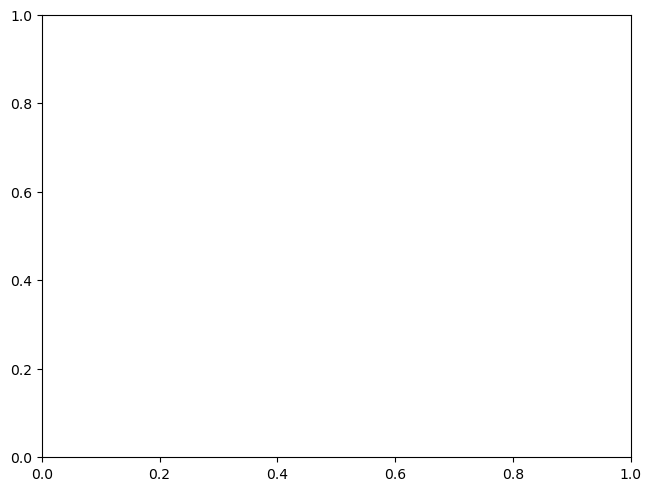

In [16]:
sq.pl.spatial_scatter(ad_ge, color=["bzw2"], shape=None)

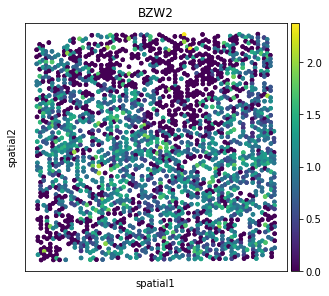

In [18]:
sq.pl.spatial_scatter(adata_sp_b, color=["BZW2"], shape=None)